# Constructing the forward model

This section will cover how to contruct the head model (the forward model implemented as a lead field matrix) to be used in source modeling. This will done based on the structural T1 MRI. To download the scan, go to  https://doi.org/10.6084/m9.figshare.16661374.


The model will be alinged to head postion of the subject in the MEG system. Note that this seciton requires access to FreeSurfer (a Unix/Linux software). For more details see https://mne.tools/stable/auto_tutorials/forward/30_forward.html

## Preparation

Import the relevant Python modules:

In [ ]:
# mount the drive (you'll have to click through the popup to allow it)
# google colab friendship block

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install openneuro-py
!pip install --upgrade mne-bids[full]
!pip install ipympl  # for the widgets in ipynb
!pip install pyvistaqt

clear_output()  # just clear everything because the output is gross and unnecessary

In [ ]:
import os.path as op

import mne
from mne_bids import BIDSPath, read_raw_bids

Then set the file names and paths:

In [ ]:
subject = 'CB069'
session = '1'
task = 'dur'  # name of the task
run = '00'
meg_suffix = 'meg'
mri_suffix = 'T1w'
epo_suffix = 'epo'
bem_suffix = 'bem-sol'
src_suffix = 'src'
fwd_suffix = 'fwd'
trans_suffix = 'trans'

bids_root = 'drive/MyDrive/GripS MEG/Data/COGITATE'
deriv_root = 'drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/analysis'

fs_subject = 'sub-CB069_ses-1'  # name of subject from freesurfer


# Files and directories for input
bids_path = BIDSPath(subject=subject, session=session, task=task, run=run, suffix=epo_suffix, datatype='meg', root=deriv_root, extension='.fif', check=False)
raw_path = bids_path.copy().update(root=bids_root, suffix=meg_suffix, extension='.fif', run='01', check=False)


print("\n*** Input files ***")
print("* Raw fiff-file (with digitization points) :", raw_path)

print("* Epoched file: ",bids_path)


mri_root = BIDSPath(subject=subject, session=session, root=bids_root, datatype='anat', suffix=mri_suffix, extension='.nii.gz')
print("* MRI file: ",mri_root)


fs_root = op.join(bids_root, 'derivatives', 'FreeSurfer')
print("* Freesurfer directory: ",fs_root)

# Files and directories for generated output

print("\n*** Output files ***")

fwd_fname = bids_path.basename.replace(epo_suffix, fwd_suffix)
fwd_file = op.join(bids_path.directory, fwd_fname)
print("* Forward model: ",fwd_file)

src_file = fwd_file.replace(fwd_suffix, src_suffix)
print("* Brain surface file: ",src_file)

trans_file = "/content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/coreg/sub-CB069/ses-1/meg/sub-CB069_ses-1_trans.fif"
print("* Tranformation file: ",trans_file)

bem_file = fwd_file.replace(fwd_suffix, bem_suffix)
print("* Boundary element file: ",bem_file)


*** Input files ***
* Raw fiff-file (with digitization points) : drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_meg.fif
* Epoched file:  drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/analysis/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-00_epo.fif
* MRI file:  drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/anat/sub-CB069_ses-1_T1w.nii.gz
* Freesurfer directory:  drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer

*** Output files ***
* Forward model:  drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/analysis/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-00_fwd.fif
* Brain surface file:  drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/analysis/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-00_src.fif
* Tranformation file:  /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/coreg/sub-CB069/ses-1/meg/sub-CB069_ses-1_trans.fif
* Boundary element file:  drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/anal

## Perform surface reconstruction using FreeSurfer and MNE:

A first requirement is that the MRI data are in NifTI (.nii) format. Converion from DICOM  to NifTI can be done e.g. using [MRIcro](https://people.cas.sc.edu/rorden/mricro/mricro.html)
The NifTI file for this tutorial is *T1_anon_defaced.nii* . Its the T1 MRI which has been 'de-faced' in order to anonymize the data.

[FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) provides the functionality for performing the cortical reconstuction using the [recon-all](https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all/).

This must be done in Unix/Linux:

> recon-all -i T1_anon_defaced.nii -s T1_anon_defaced -all


To perform the scalp surface reconstruction to be used in MNE-Python using the command from the terminal:

> mne make_scalp_surfaces --overwrite --subject T1_anon_defaced --force


To create the BEM, execute the terminal command:

> mne watershed_bem --overwrite --subject t1_anon_defaced
    
For a convinient batch script performing these commands see [my_recon.sh](https://github.com/Neuronal-Oscillations/FLUX/blob/main/MNEPython/my_recon.sh) on GitHub
    
The next step is to read and illustrate the brain surface generated from FreeSurfer.

## Inspecting the surface reconstruction

In order to verify that the surface has been constructed and the fif-file created plot the output:

In [ ]:
!pip install xvfbwrapper

  Preparing metadata (setup.py) ... done
  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-py3-none-any.whl size=5009 sha256=8e6eccf17ddb5d80337f00763bfde835346a8e845e5c14c638e01cb4955d0164
  Stored in directory: /root/.cache/pip/wheels/cb/10/7d/2b7fdffccf837f7d5425931575fbee9caebe2c190931f9058b
Successfully built xvfbwrapper


In [ ]:
#!apt-get update

#!apt-get install x11-utils > /dev/null 2>&1
#!pip install pyglet > /dev/null 2>&1
#!apt-get install -y xvfb python-opengl > /dev/null 2>&1

#!apt-get install -y xvfb python-opengl ffmpeg
#!pip install pyvirtualdisplay
#!pip install vtk

#display = Display(visible=0, size=(800, 600))
#display.start()

NameError: name 'Display' is not defined

In [ ]:
!which Xvfb

In [ ]:
%matplotlib inline
Brain = mne.viz.get_brain_class()

brain = Brain(fs_subject, hemi='lh', surf='pial', subjects_dir=fs_root, size=(800, 600), show=False)

brain.add_annotation('aparc.a2009s', borders=False)

RuntimeError: Using the notebook backend on Linux requires a compatible VTK setup. Consider using Xfvb or xvfb-run to set up a working virtual display, or install VTK with OSMesa enabled.


![surface.PNG](attachment:surface.PNG)

Above shows the parcellated brain surface. We are not going to use the parcellation here; however, it is wise to use the output to check that the brain surface has been correctly reconstructed.

## Creating the boundary element model (BEM) surfaces

Now that the surface of the MRI has been recontructed the boundary element model (BEM) can be created. As this will be used for MEG source reconstruction, we will prepare a single shell model by setting `conductivity = (0.3,)` . The `ico` parameter serves to downsample the model and it can be increased to reduce the computational demands.

In [ ]:
conductivity = (0.3,)
model = mne.make_bem_model(fs_subject,
                           ico=4,
                           conductivity=conductivity,
                           subjects_dir=fs_root)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is   1.69 -10.96  41.97 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


Now save the BEM model:

In [ ]:
mne.write_bem_solution(bem_file,
                       bem, overwrite=True)

Overwriting existing file.


and visualize:

Using surface: /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/bem/inner_skull.surf
Using surface: /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/bem/outer_skull.surf
Using surface: /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/bem/outer_skin.surf


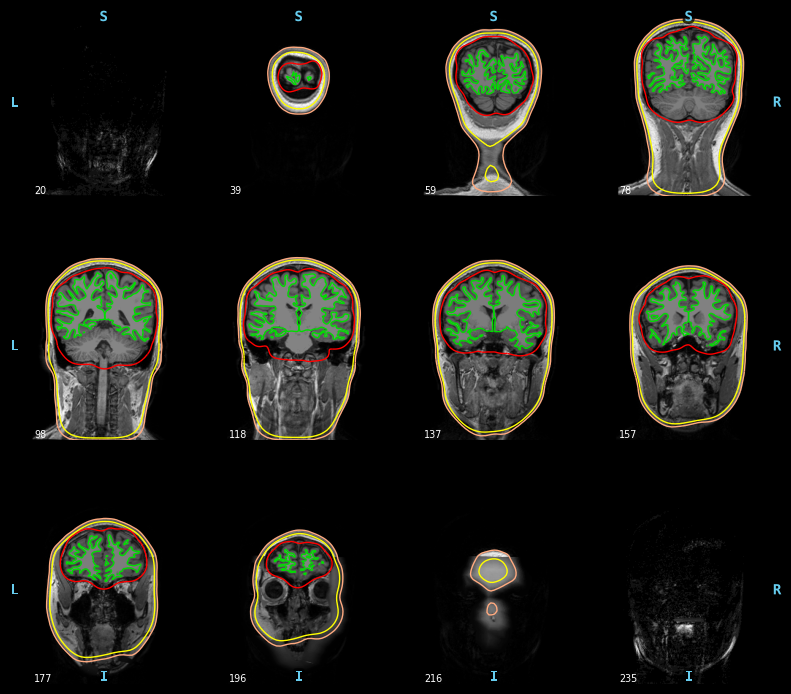

In [ ]:
_=mne.viz.plot_bem(subject=fs_subject,
                subjects_dir=fs_root,
                brain_surfaces='white',
                orientation='coronal')

In the above plots please check that the brain surface has been identified correctly.

## Co-registration with anatomical landmars

The next step involves the spatial alignment of MEG sensor space in relation to digitized scalp landmarks,the HPI coils and the MRI volumes. This alignment is used when deriving the forward solution. It requires working with the MNE-Python-coregistration GUI software. Further support and explanations can be found in this video:
https://youtu.be/ALV5qqMHLlQ .
The output of the manual coregistration is the transformation file we will be using later in the script.

For the file to save used the name from *trans_file*:

In [ ]:
print(trans_file)

/content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/coreg/sub-CB069/ses-1/meg/sub-CB069_ses-1_trans.fif


For the raw fiff-file with digitized data use <raw_path>:

In [ ]:
print(raw_path)

drive/MyDrive/GripS MEG/Data/COGITATE/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-01_meg.fif


In [ ]:
%matplotlib qt
mne.gui.coregistration(subject=fs_subject, subjects_dir=fs_root)

![coregistration.PNG](attachment:coregistration.PNG)

In [ ]:
print(trans_file)

/content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/coreg/sub-CB069/ses-1/meg/sub-CB069_ses-1_trans.fif


In [ ]:
info = read_raw_bids(bids_path=raw_path, verbose=False).info
print(info)
mne.viz.plot_alignment(info, trans="/content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/coreg/sub-CB069/ses-1/meg/sub-CB069_ses-1_trans.fif", subject=fs_subject, dig=True,
                           meg=['helmet', 'sensors'], subjects_dir=fs_root,
                           surfaces='head-dense')

<Info | 25 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, BIO002, BIO003, EEG001, EEG002, EEG003, EEG004, EEG005, ...
 chs: 1 EOG, 12 misc, 64 EEG, 11 Internal Active Shielding data (Triux systems), 102 Magnetometers, 204 Gradiometers, 9 Stimulus, 1 System status channel information (Triux systems)
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 dig: 129 items (3 Cardinal, 4 HPI, 65 EEG, 57 Extra)
 events: 1 item (list)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 maxshield: True
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 404
 proc_history: 1 item (list)
 proj_name: mne_anonymize
 projs: generated with autossp-1.0.1: off, ge

RuntimeError: Using the notebook backend on Linux requires a compatible VTK setup. Consider using Xfvb or xvfb-run to set up a working virtual display, or install VTK with OSMesa enabled.

![aligmnsment.PNG](attachment:aligmnsment.PNG)

Here it is important to check that the fiducial points by the nasion and the preauriculars are well placed.

## Computing the sources according to the BEM model

To construct volumetric forward model, the 'source space' must be set up. The source space is defined by a grid (5 mm between grid points) covering the volume of the brain.  

In [ ]:
surface = op.join(fs_root, fs_subject, 'bem', 'inner_skull.surf')
src = mne.setup_source_space(
    fs_subject, spacing="oct4", add_dist="patch", subjects_dir=fs_root
)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer
Subject      = sub-CB069_ses-1
Surface      = white
Octahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/surf/lh.white...
Mapping lh sub-CB069_ses-1 -> oct (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 258/155732 selected to source space (oct = 4)

Loading /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/surf/rh.white...
Mapping rh sub-CB069_ses-1 -> oct (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /content/drive/MyDrive/GripS M

In [ ]:
surface

'drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/bem/inner_skull.surf'

and then save it:

In [ ]:
mne.write_source_spaces(src_file, src, overwrite=True)

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


To visualize the source set write:

Using surface: /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/bem/inner_skull.surf
Using surface: /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/bem/outer_skull.surf
Using surface: /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/FreeSurfer/sub-CB069_ses-1/bem/outer_skin.surf


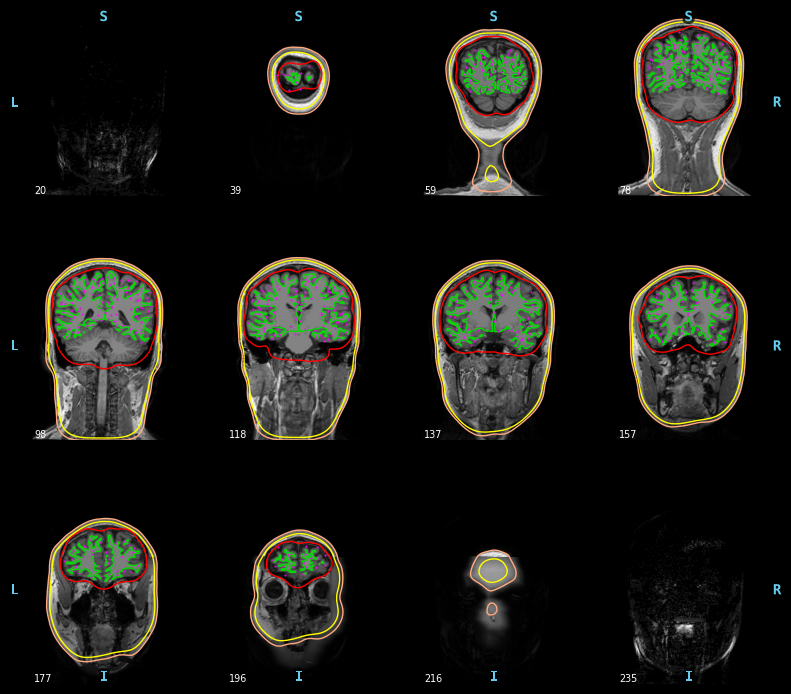

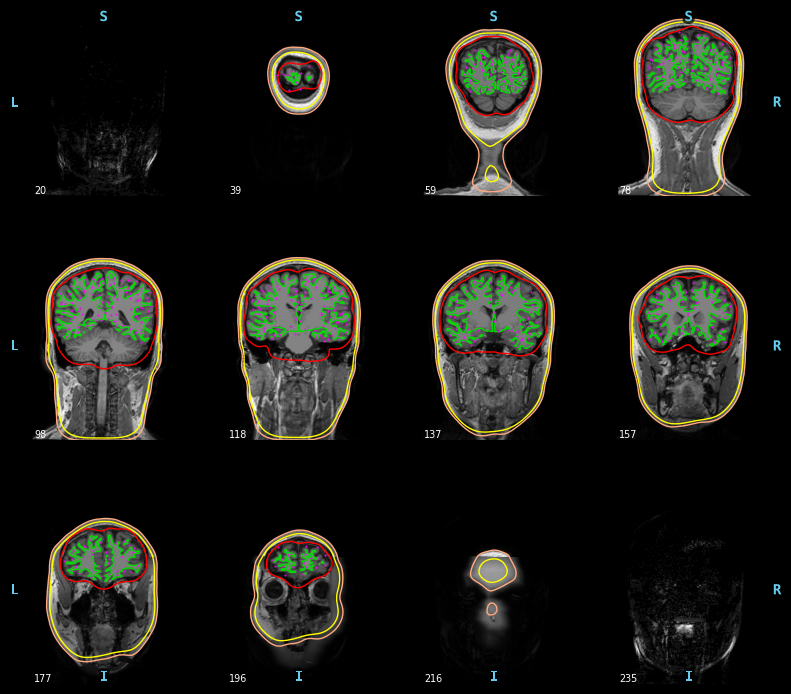

In [ ]:
mne.viz.plot_bem(subject=fs_subject,
                     subjects_dir=fs_root,
                     brain_surfaces='white',
                     src=src,
                     orientation='coronal')

Note that the grid coverts the brain.

## Construting the forward model

The last step is to construct the forward model by assigning a lead-field to each source location in relation to the head position with respect to the sensors.  This will result in the lead-field matrix (*fwd*).

In [ ]:
fwd = mne.make_forward_solution(info,
                                trans=trans_file,
                                src=src,
                                bem=bem,
                                meg=True,
                                eeg=False,
                                mindist=5.,  #TODO: minimum distance of sources from inner skull surface (in mm); can be 2.5
                                n_jobs=-1,
                                verbose=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155732, n_used=258>, <surface (rh), n_vertices=155772, n_used=258>] MRI (surface RAS) coords, subject 'sub-CB069_ses-1', ~28.6 MB>
MRI -> head transform : /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/coreg/sub-CB069/ses-1/meg/sub-CB069_ses-1_trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 516 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999772 -0.011688 -0.017882       2.07 mm
    0.012564 0.998686 0.049675      13.20 mm
    0.017278 -0.049888 0.998605       9.26 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.997390 -0.071437 0.010481       3.28 mm
    0.069209 0.987279 0.143146       1.24 mm


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    Found   0/172 points outside using solid angles
    Total 258/258 points inside the surface
Interior check completed in 29452.1 ms
Checking surface interior status for 258 points...
    Found  82/258 points inside  an interior sphere of radius   50.6 mm
    Found   0/258 points outside an exterior sphere of radius   96.3 mm
    Found   0/176 points outside using surface Qhull


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


    Found   0/176 points outside using solid angles


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s finished


    Total 258/258 points inside the surface
Interior check completed in 1200.0 ms

Checking surface interior status for 306 points...
    Found   0/306 points inside  an interior sphere of radius   50.6 mm
    Found 306/306 points outside an exterior sphere of radius   96.3 mm
    Found   0/  0 points outside using surface Qhull
    Found   0/  0 points outside using solid angles
    Total 0/306 points inside the surface
Interior check completed in 248.7 ms

Composing the field computation matrix...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Computing MEG at 516 source locations (free orientations)...


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.



Finished.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    8.2s finished


Finally, save the forward models:

In [ ]:
mne.write_forward_solution(fwd_file, fwd, overwrite=True)

    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


## Preregistraion and publications

Publication, example:

"Structural magnetic resonance images (MRIs) were acquired using a 3 Tesla Siemens MAGNETOM Prisma whole-body scanner (Siemens AG; TE = 2 ms, and TR = 2 s). The raw T1 weighted images were converted from DICOM to NIFTI. The MRIs were de-faced to anonymize the participant. The coordinate system of the participants' individual MRI was aligned to the anatomic landmarks (nasion as well as the left and right preauricular points) and the scalp shapes digitized before the recordings. The alignment according to the MEG sensor array was done relative to four digitized head position indicator (HPI) coils. A single shell boundary elements model (BEM) was constructed based on the brain surface derived using Freesurfer (Dale et al., 1999; Destrieux et al., 2010). This was then used to construct a volumetric forward model (5 mm grid) covering the full brain volume. The lead field matrix was then calculated according the head-position with respect to MEG sensor array. "


## References

Dale, A.M., Fischl, B., and Sereno, M.I. (1999). Cortical surface-based analysis: I. segmentation and surface reconstruction. NeuroImage, 9(2):179–194.

Destrieux, C., Fischl, B., Dale, A., and Halgren, E. (2010) Automatic parcellation of human cortical gyri and sulci using standard anatomical nomenclature. NeuroImage, 53(1):1–15.
